In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib as mpl
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from astropy.convolution.kernels import CustomKernel

from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

In [2]:
%matplotlib inline

In [3]:
plt.style.use('court.mplstyle')

In [4]:
# https://dsp.stackexchange.com/questions/1676/savitzky-golay-smoothing-filter-for-not-equally-spaced-data

def non_uniform_savgol(x, y, window, polynom):
    """
    Applies a Savitzky-Golay filter to y with non-uniform spacing
    as defined in x

    This is based on https://dsp.stackexchange.com/questions/1676/savitzky-golay-smoothing-filter-for-not-equally-spaced-data
    The borders are interpolated like scipy.signal.savgol_filter would do

    Parameters
    ----------
    x : array_like
        List of floats representing the x values of the data
    y : array_like
        List of floats representing the y values. Must have same length
        as x
    window : int (odd)
        Window length of datapoints. Must be odd and smaller than x
    polynom : int
        The order of polynom used. Must be smaller than the window size

    Returns
    -------
    np.array of float
        The smoothed y values
    """
    if len(x) != len(y):
        raise ValueError('"x" and "y" must be of the same size')

    if len(x) < window:
        raise ValueError('The data size must be larger than the window size')

    if type(window) is not int:
        raise TypeError('"window" must be an integer')

    if window % 2 == 0:
        raise ValueError('The "window" must be an odd integer')

    if type(polynom) is not int:
        raise TypeError('"polynom" must be an integer')

    if polynom >= window:
        raise ValueError('"polynom" must be less than "window"')

    half_window = window // 2
    polynom += 1

    # Initialize variables
    A = np.empty((window, polynom))     # Matrix
    tA = np.empty((polynom, window))    # Transposed matrix
    t = np.empty(window)                # Local x variables
    y_smoothed = np.full(len(y), np.nan)

    # Start smoothing
    for i in range(half_window, len(x) - half_window, 1):
        # Center a window of x values on x[i]
        for j in range(0, window, 1):
            t[j] = x[i + j - half_window] - x[i]

        # Create the initial matrix A and its transposed form tA
        for j in range(0, window, 1):
            r = 1.0
            for k in range(0, polynom, 1):
                A[j, k] = r
                tA[k, j] = r
                r *= t[j]

        # Multiply the two matrices
        tAA = np.matmul(tA, A)

        # Invert the product of the matrices
        tAA = np.linalg.inv(tAA)

        # Calculate the pseudoinverse of the design matrix
        coeffs = np.matmul(tAA, tA)

        # Calculate c0 which is also the y value for y[i]
        y_smoothed[i] = 0
        for j in range(0, window, 1):
            y_smoothed[i] += coeffs[0, j] * y[i + j - half_window]

        # If at the end or beginning, store all coefficients for the polynom
        if i == half_window:
            first_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    first_coeffs[k] += coeffs[k, j] * y[j]
        elif i == len(x) - half_window - 1:
            last_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    last_coeffs[k] += coeffs[k, j] * y[len(y) - window + j]

    # Interpolate the result at the left border
    for i in range(0, half_window, 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += first_coeffs[j] * x_i
            x_i *= x[i] - x[half_window]

    # Interpolate the result at the right border
    for i in range(len(x) - half_window, len(x), 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += last_coeffs[j] * x_i
            x_i *= x[i] - x[-half_window - 1]

    return y_smoothed

In [5]:
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_WISEJ194218.38-203247.5_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_AOHer_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-14_ATLAS.csv')
atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-16_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-19_ATLAS.csv')
atlas

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.332892,11.704,0.002,75568.0,115.0,o,0,198.82,258.5602,-21.43715,9004.97,6972.30,3.77,3.32,-89.2,-0.521,18.59,19.68,02a57228o0112o
1,57228.358031,11.772,0.002,71008.0,109.0,o,0,341.84,258.5602,-21.43715,7555.78,8447.68,3.52,3.27,-82.7,-0.493,18.63,19.71,02a57228o0139o
2,57228.384681,11.780,0.002,70498.0,111.0,o,0,200.04,258.5602,-21.43715,7556.18,8451.22,3.55,3.27,-82.0,-0.488,18.61,19.69,02a57228o0168o
3,57241.302627,13.036,0.003,22165.0,57.0,c,0,47.52,258.5602,-21.43715,8759.65,7196.66,4.18,3.90,81.4,-0.424,19.26,21.15,02a57241o0080c
4,57241.318127,13.035,0.003,22172.0,56.0,c,0,75.89,258.5602,-21.43715,8756.69,7196.23,4.04,3.71,82.3,-0.439,19.31,21.17,02a57241o0102c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2359,60109.225318,12.690,0.002,30479.0,64.0,c,0,732.01,258.5602,-21.43715,8687.03,3673.52,2.59,2.04,-19.8,-0.391,19.34,21.23,04a60109o0591c
2360,60109.253950,12.684,0.002,30653.0,64.0,c,0,1136.38,258.5602,-21.43715,8668.32,3771.22,2.62,2.04,-21.2,-0.395,19.31,21.13,04a60109o0645c
2361,60110.216947,12.659,0.002,31364.0,65.0,c,0,466.99,258.5602,-21.43715,2634.69,3542.08,2.09,1.89,52.8,-0.404,19.30,21.15,04a60110o0597c
2362,60110.221674,12.648,0.002,31667.0,66.0,c,0,507.44,258.5602,-21.43715,2656.76,3577.09,2.11,1.84,47.3,-0.407,19.35,21.17,04a60110o0607c


In [6]:
oband = atlas[atlas['f']=='o']
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.332892,11.704,0.002,75568.0,115.0,o,0,198.82,258.5602,-21.43715,9004.97,6972.30,3.77,3.32,-89.2,-0.521,18.59,19.68,02a57228o0112o
1,57228.358031,11.772,0.002,71008.0,109.0,o,0,341.84,258.5602,-21.43715,7555.78,8447.68,3.52,3.27,-82.7,-0.493,18.63,19.71,02a57228o0139o
2,57228.384681,11.780,0.002,70498.0,111.0,o,0,200.04,258.5602,-21.43715,7556.18,8451.22,3.55,3.27,-82.0,-0.488,18.61,19.69,02a57228o0168o
18,57256.259894,11.739,0.003,73183.0,222.0,o,0,32.29,258.5602,-21.43715,8758.93,7203.53,3.99,3.15,88.6,-0.523,17.74,18.63,02a57256o0020o
19,57288.260121,11.619,0.002,81744.0,152.0,o,0,132.62,258.5602,-21.43715,8778.71,7202.44,3.81,3.19,86.3,-0.518,18.28,19.09,02a57288o0080o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346,60085.248931,11.586,0.001,84283.0,106.0,o,0,6728.27,258.5602,-21.43715,10367.22,8115.25,2.57,2.26,-11.8,-0.428,19.14,20.58,04a60085o0655o
2347,60085.249381,11.582,0.001,84589.0,100.0,o,0,3327.73,258.5602,-21.43715,356.11,8036.68,2.59,2.11,-84.3,-0.383,18.96,20.57,04a60085o0656o
2348,60085.274811,11.626,0.001,81202.0,101.0,o,0,9386.05,258.5602,-21.43715,10413.15,2481.09,2.69,2.19,-25.3,-0.421,18.93,20.68,04a60085o0710o
2355,60102.015310,11.675,0.001,77606.0,106.0,o,0,408.87,258.5602,-21.43715,9566.46,90.56,3.65,2.36,-0.8,-0.490,18.37,19.06,03a60102o0699o


In [7]:
oband = oband.sort_values(by=['mjd'],axis=0,ascending=True,ignore_index=True)
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.332892,11.704,0.002,75568.0,115.0,o,0,198.82,258.5602,-21.43715,9004.97,6972.30,3.77,3.32,-89.2,-0.521,18.59,19.68,02a57228o0112o
1,57228.358031,11.772,0.002,71008.0,109.0,o,0,341.84,258.5602,-21.43715,7555.78,8447.68,3.52,3.27,-82.7,-0.493,18.63,19.71,02a57228o0139o
2,57228.384681,11.780,0.002,70498.0,111.0,o,0,200.04,258.5602,-21.43715,7556.18,8451.22,3.55,3.27,-82.0,-0.488,18.61,19.69,02a57228o0168o
3,57256.259894,11.739,0.003,73183.0,222.0,o,0,32.29,258.5602,-21.43715,8758.93,7203.53,3.99,3.15,88.6,-0.523,17.74,18.63,02a57256o0020o
4,57288.260121,11.619,0.002,81744.0,152.0,o,0,132.62,258.5602,-21.43715,8778.71,7202.44,3.81,3.19,86.3,-0.518,18.28,19.09,02a57288o0080o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712,60085.248931,11.586,0.001,84283.0,106.0,o,0,6728.27,258.5602,-21.43715,10367.22,8115.25,2.57,2.26,-11.8,-0.428,19.14,20.58,04a60085o0655o
1713,60085.249381,11.582,0.001,84589.0,100.0,o,0,3327.73,258.5602,-21.43715,356.11,8036.68,2.59,2.11,-84.3,-0.383,18.96,20.57,04a60085o0656o
1714,60085.274811,11.626,0.001,81202.0,101.0,o,0,9386.05,258.5602,-21.43715,10413.15,2481.09,2.69,2.19,-25.3,-0.421,18.93,20.68,04a60085o0710o
1715,60102.015310,11.675,0.001,77606.0,106.0,o,0,408.87,258.5602,-21.43715,9566.46,90.56,3.65,2.36,-0.8,-0.490,18.37,19.06,03a60102o0699o


In [8]:
oband = oband.drop_duplicates(subset=['mjd'],ignore_index=True) 
    # this keeps the first entry, I'd love if it took an average
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.332892,11.704,0.002,75568.0,115.0,o,0,198.82,258.5602,-21.43715,9004.97,6972.30,3.77,3.32,-89.2,-0.521,18.59,19.68,02a57228o0112o
1,57228.358031,11.772,0.002,71008.0,109.0,o,0,341.84,258.5602,-21.43715,7555.78,8447.68,3.52,3.27,-82.7,-0.493,18.63,19.71,02a57228o0139o
2,57228.384681,11.780,0.002,70498.0,111.0,o,0,200.04,258.5602,-21.43715,7556.18,8451.22,3.55,3.27,-82.0,-0.488,18.61,19.69,02a57228o0168o
3,57256.259894,11.739,0.003,73183.0,222.0,o,0,32.29,258.5602,-21.43715,8758.93,7203.53,3.99,3.15,88.6,-0.523,17.74,18.63,02a57256o0020o
4,57288.260121,11.619,0.002,81744.0,152.0,o,0,132.62,258.5602,-21.43715,8778.71,7202.44,3.81,3.19,86.3,-0.518,18.28,19.09,02a57288o0080o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712,60085.248931,11.586,0.001,84283.0,106.0,o,0,6728.27,258.5602,-21.43715,10367.22,8115.25,2.57,2.26,-11.8,-0.428,19.14,20.58,04a60085o0655o
1713,60085.249381,11.582,0.001,84589.0,100.0,o,0,3327.73,258.5602,-21.43715,356.11,8036.68,2.59,2.11,-84.3,-0.383,18.96,20.57,04a60085o0656o
1714,60085.274811,11.626,0.001,81202.0,101.0,o,0,9386.05,258.5602,-21.43715,10413.15,2481.09,2.69,2.19,-25.3,-0.421,18.93,20.68,04a60085o0710o
1715,60102.015310,11.675,0.001,77606.0,106.0,o,0,408.87,258.5602,-21.43715,9566.46,90.56,3.65,2.36,-0.8,-0.490,18.37,19.06,03a60102o0699o


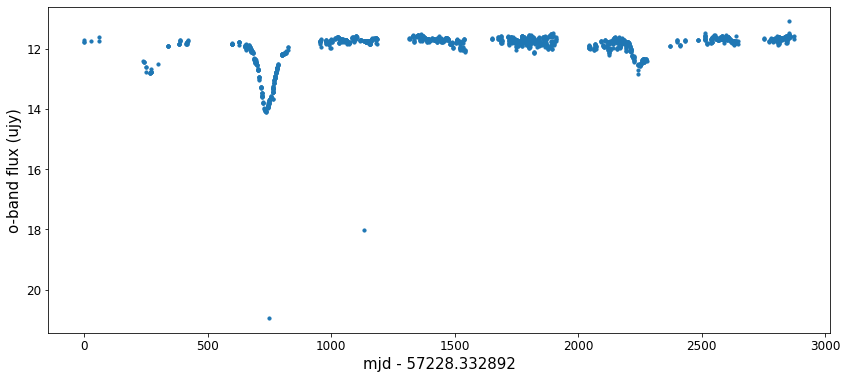

In [9]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10)#/(80000),s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band flux (ujy)')
# plt.ylim(top=1.2)
# plt.ylim(0.6,1.2)
# plt.xlim(1000,2000)
plt.show()

In [10]:
median_filtered = sp.signal.medfilt(oband['m'],kernel_size=5)

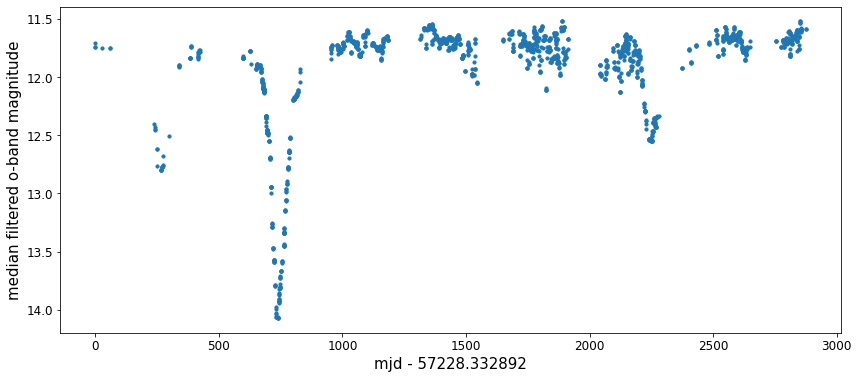

In [11]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],median_filtered,s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('median filtered o-band magnitude')
plt.show()

In [12]:
savgol_filtered = non_uniform_savgol(np.asarray(oband['mjd']-oband['mjd'][0]),
                                     np.asarray(oband['m']),
                                   window=7, polynom=1)

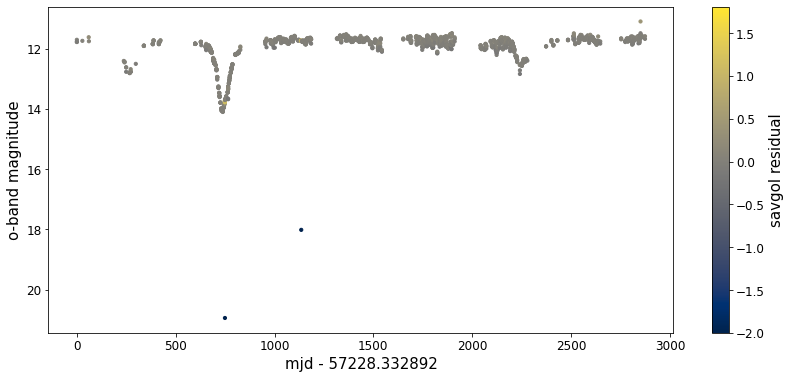

In [13]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10,
            c=savgol_filtered-oband['m'],cmap='cividis')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band magnitude')
plt.colorbar(label='savgol residual')
# plt.clim(vmax=-1)
plt.clim(vmin=-2)
plt.show()

0.20867581315350736


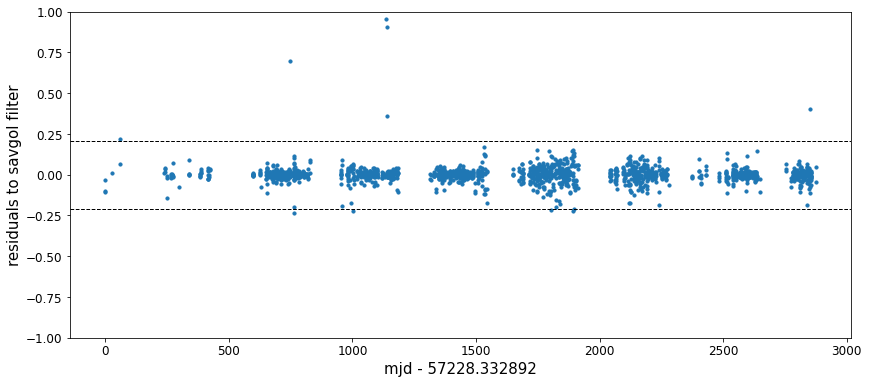

In [14]:
deviation = np.std(savgol_filtered-oband['m'])
print(deviation)

plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],savgol_filtered-oband['m'],s=10)
plt.axhline(deviation,color='k',linestyle='--')
plt.axhline(-deviation,color='k',linestyle='--')
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('residuals to savgol filter')
plt.ylim(-1,1)
plt.show()

In [15]:
# plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10,
#             c=median_filtered-oband['m'],cmap='cividis')
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('o-band magnitude')
# plt.colorbar(label='median residual')
# # plt.clim(vmax=-1)
# plt.clim(vmin=-2)
# plt.show()

In [16]:
# deviation = np.std((median_filtered-oband['m']))
# print(deviation)

# plt.figure(figsize=(14,6))
# # plt.axvline(oband['mjd'][1000]-oband['mjd'][0])
# plt.scatter(oband['mjd']-oband['mjd'][0],median_filtered-oband['m'],s=10)
# plt.axhline(deviation,color='k',linestyle='--')
# plt.axhline(-deviation,color='k',linestyle='--')
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('residuals to median filter')
# plt.ylim(-1,1)
# plt.show()

In [17]:
mask = np.where(np.abs(savgol_filtered-oband['m'])<deviation,True,False)
mask

# mask = np.where(np.abs(median_filtered-oband['m'])<0.25,True,False)
# mask

array([ True,  True,  True, ...,  True,  True,  True])

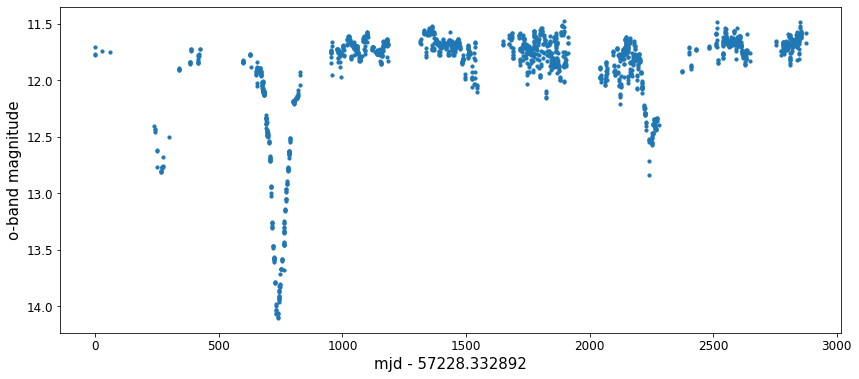

In [18]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd'][mask]-oband['mjd'][0],oband['m'][mask],s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band magnitude')
plt.show()

In [19]:
# median_filtered_oband = oband.iloc[mask]
# median_filtered_oband.reset_index(drop=True,inplace=True)
# median_filtered_oband

savgol_filtered_oband = oband.iloc[mask]
savgol_filtered_oband.reset_index(drop=True,inplace=True)
savgol_filtered_oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.332892,11.704,0.002,75568.0,115.0,o,0,198.82,258.5602,-21.43715,9004.97,6972.30,3.77,3.32,-89.2,-0.521,18.59,19.68,02a57228o0112o
1,57228.358031,11.772,0.002,71008.0,109.0,o,0,341.84,258.5602,-21.43715,7555.78,8447.68,3.52,3.27,-82.7,-0.493,18.63,19.71,02a57228o0139o
2,57228.384681,11.780,0.002,70498.0,111.0,o,0,200.04,258.5602,-21.43715,7556.18,8451.22,3.55,3.27,-82.0,-0.488,18.61,19.69,02a57228o0168o
3,57256.259894,11.739,0.003,73183.0,222.0,o,0,32.29,258.5602,-21.43715,8758.93,7203.53,3.99,3.15,88.6,-0.523,17.74,18.63,02a57256o0020o
4,57289.256053,11.753,0.054,72216.0,3903.0,o,0,1.27,258.5602,-21.43715,8772.38,7208.08,4.05,3.29,87.4,-0.534,15.54,15.57,02a57289o0099o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1694,60085.248931,11.586,0.001,84283.0,106.0,o,0,6728.27,258.5602,-21.43715,10367.22,8115.25,2.57,2.26,-11.8,-0.428,19.14,20.58,04a60085o0655o
1695,60085.249381,11.582,0.001,84589.0,100.0,o,0,3327.73,258.5602,-21.43715,356.11,8036.68,2.59,2.11,-84.3,-0.383,18.96,20.57,04a60085o0656o
1696,60085.274811,11.626,0.001,81202.0,101.0,o,0,9386.05,258.5602,-21.43715,10413.15,2481.09,2.69,2.19,-25.3,-0.421,18.93,20.68,04a60085o0710o
1697,60102.015310,11.675,0.001,77606.0,106.0,o,0,408.87,258.5602,-21.43715,9566.46,90.56,3.65,2.36,-0.8,-0.490,18.37,19.06,03a60102o0699o


In [20]:
iter_savgol_filtered = non_uniform_savgol(np.asarray(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0]),
                                     np.asarray(savgol_filtered_oband['m']),
                                   window=7, polynom=1)

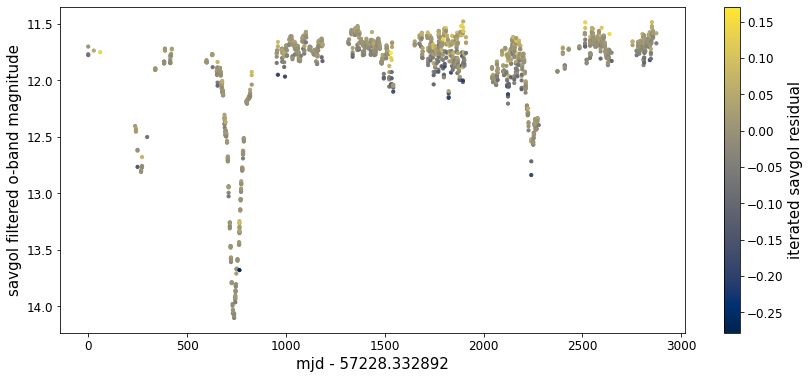

In [21]:
plt.figure(figsize=(14,6))
plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],savgol_filtered_oband['m'],s=10,
            c=iter_savgol_filtered-savgol_filtered_oband['m'],cmap='cividis')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('savgol filtered o-band magnitude')
plt.colorbar(label='iterated savgol residual')
# plt.clim(vmax=-1)
# plt.clim(vmin=-2)
plt.show()

0.04000249570136507


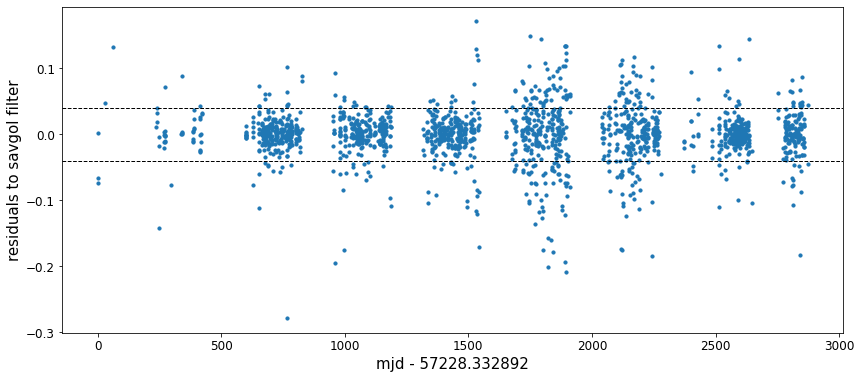

In [22]:
deviation = np.std(iter_savgol_filtered-savgol_filtered_oband['m'])
print(deviation)

plt.figure(figsize=(14,6))
plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],
            iter_savgol_filtered-savgol_filtered_oband['m'],s=10)
plt.axhline(deviation,color='k',linestyle='--')
plt.axhline(-deviation,color='k',linestyle='--')
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('residuals to savgol filter')
# plt.ylim(-1,1)
plt.show()

In [23]:
mjd_scale = savgol_filtered_oband['mjd'][0]

# median_filtered_oband['mjd']-mjd_scale,savgol_filtered
time = savgol_filtered_oband['mjd']-mjd_scale

# stddev_arr = []
# saturation_mask = [False,False,False,False,False]
deviation = np.std(iter_savgol_filtered-savgol_filtered_oband['m'])
# print(deviation)

### find the gaps in the data
time_diff = np.diff(time)
time_diff = np.append(time_diff,0)

gap_mask = []#[False,False]
for i in range(0,len(time)):
    if time_diff[i] > 50:
        gap_mask.append(True)
#     elif (gap_mask[i-1] == True and gap_mask[i-2] == False):
#         gap_mask.append(True)
    else:
        gap_mask.append(False)
        
noise_mask = np.full(len(time),False)
for i in range(0,len(time[gap_mask])):
    if i == 0:
        window = time<=time[time[gap_mask].index[i]]
#         print(window)
    elif i == len(time[gap_mask])-1:
        window = time>=time[time[gap_mask].index[i]]
#         print(window)
    else:
        window = np.logical_and(time>=time[time[gap_mask].index[i]],time<=time[time[gap_mask].index[i+1]])
#     print(np.std(iter_savgol_filtered[window]-np.asarray(savgol_filtered_oband['m'])[window]))
#     print(np.mean(np.asarray(savgol_filtered_oband['m'])[window])-np.min(savgol_filtered_oband['m']))
#     print(np.max(np.asarray(savgol_filtered_oband['m'])[window])-np.min(savgol_filtered_oband['m']))
    if (np.std(iter_savgol_filtered[window]-np.asarray(savgol_filtered_oband['m'])[window]) > deviation 
        and len(savgol_filtered_oband['m'][window]) > 50 and 
        (np.max(np.asarray(savgol_filtered_oband['m'])[window])-np.min(np.asarray(savgol_filtered_oband['m'])[window])) < 2.5
       and (np.max(np.asarray(savgol_filtered_oband['m'])[window])-np.min(savgol_filtered_oband['m'])) < 3.0):
        print(len(savgol_filtered_oband['m'][window]))
        print(np.max(np.asarray(savgol_filtered_oband['m'])[window])-np.min(np.asarray(savgol_filtered_oband['m'])[window]))
#         print(i,'mask me')
        noise_mask[window] = True
#     print('------')
noise_mask

286
0.6750000000000007
262
1.2200000000000006


array([False, False, False, ..., False, False, False])

0.04000249570136507


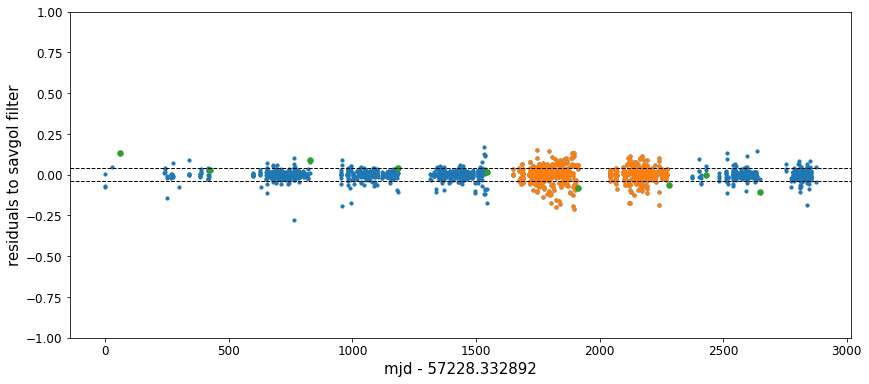

In [24]:
deviation = np.std(iter_savgol_filtered-savgol_filtered_oband['m'])
print(deviation)

plt.figure(figsize=(14,6))
plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],
            iter_savgol_filtered-savgol_filtered_oband['m'],s=10)
# plt.scatter(savgol_filtered_oband['mjd'][saturation_mask]-savgol_filtered_oband['mjd'][0],
#             iter_savgol_filtered[saturation_mask]-savgol_filtered_oband['m'][saturation_mask],s=10)
plt.scatter(savgol_filtered_oband['mjd'][noise_mask]-savgol_filtered_oband['mjd'][0],
            iter_savgol_filtered[noise_mask]-savgol_filtered_oband['m'][noise_mask],s=10)
plt.scatter(savgol_filtered_oband['mjd'][gap_mask]-savgol_filtered_oband['mjd'][0],
            iter_savgol_filtered[gap_mask]-savgol_filtered_oband['m'][gap_mask],s=30)

plt.axhline(deviation,color='k',linestyle='--')
plt.axhline(-deviation,color='k',linestyle='--')
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('residuals to savgol filter')
plt.ylim(-1,1)
plt.show()

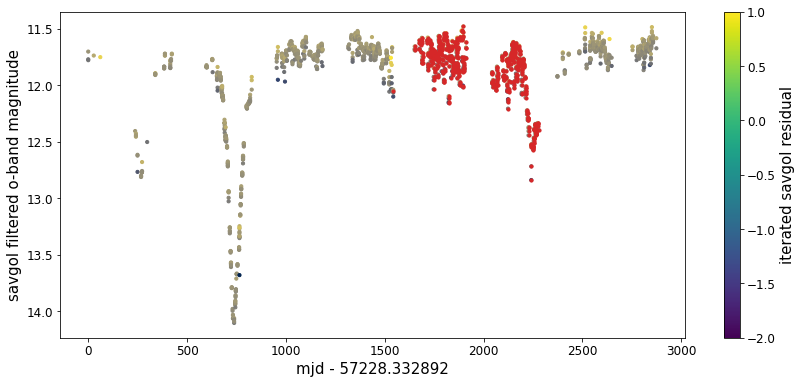

In [25]:
plt.figure(figsize=(14,6))
plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],savgol_filtered_oband['m'],s=10,
            c=iter_savgol_filtered-savgol_filtered_oband['m'],cmap='cividis')
plt.scatter(savgol_filtered_oband['mjd'][noise_mask]-savgol_filtered_oband['mjd'][0],
            savgol_filtered_oband['m'][noise_mask],s=10,color='tab:red')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('savgol filtered o-band magnitude')
plt.colorbar(label='iterated savgol residual')
# plt.clim(vmax=-1)
plt.clim(vmin=-2)
plt.show()

In [26]:
# edge_detect = sp.ndimage.convolve(oband['m'][mask], CustomKernel([1.0, 0.0, -1.0]))
edge_detect = sp.ndimage.convolve(savgol_filtered_oband['m'], [1.0, 0.0, -1.0])

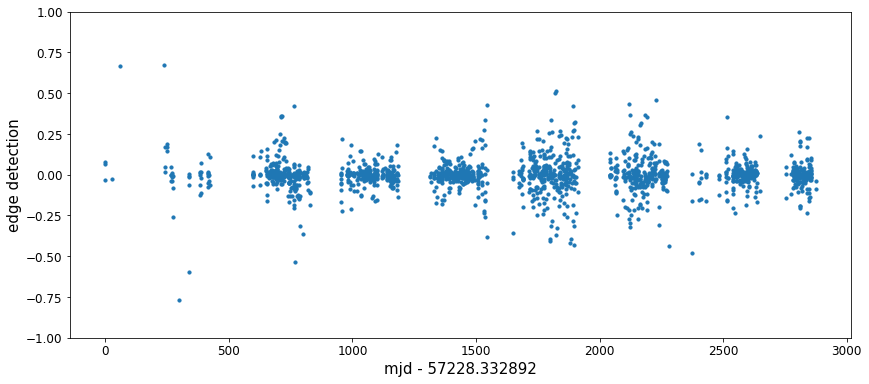

In [27]:
mjd_scale = savgol_filtered_oband['mjd'][0]


plt.figure(figsize=(14,6))
plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,edge_detect,s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('edge detection')
plt.ylim(-1,1)
plt.show()

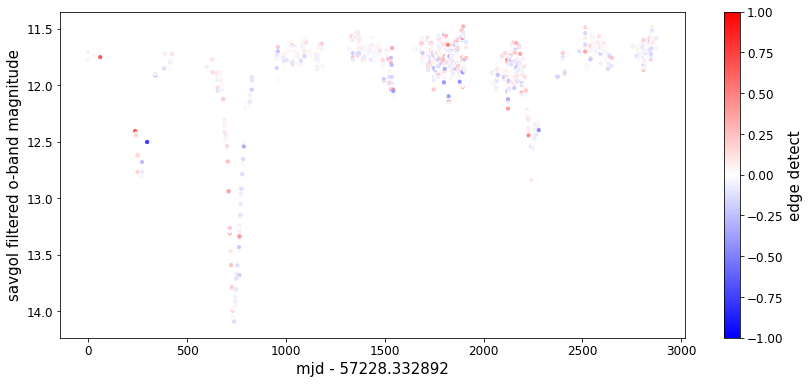

In [28]:
plt.figure(figsize=(14,6))
plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,
            c=edge_detect,cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('savgol filtered o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-1,1)
plt.show()

### added in a gaussian smooth before the interpolation here

In [29]:
# smoothed_flux = convolve(median_filtered_oband['m'], Gaussian1DKernel(20),boundary='extend')

# interpolation_function = sp.interpolate.interp1d(np.asarray(median_filtered_oband['mjd']-mjd_scale),
#                                                  np.asarray(median_filtered_oband['m']),
#                                                  kind='slinear')
interpolation_function = sp.interpolate.interp1d(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),
                                                 np.asarray(iter_savgol_filtered),
                                                 kind='slinear')
## what time resolution? I don't want to lose any of the real data if possible
real_resolution = np.median(np.diff(savgol_filtered_oband['mjd']))
len_data = np.max(savgol_filtered_oband['mjd']-mjd_scale)
resample_time = np.linspace(0,len_data,int(len_data))#int(len_data/(real_resolution/10000)))
## currently resampling at a resolution of 1 day
resample_flux = interpolation_function(resample_time)

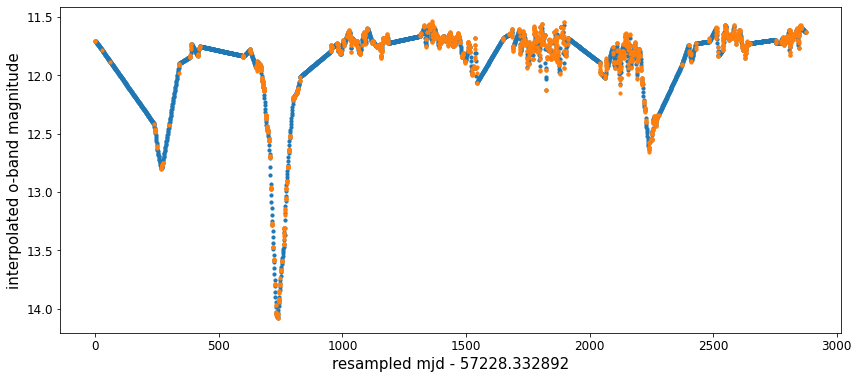

In [63]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,resample_flux,s=10)
plt.scatter(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),np.asarray(iter_savgol_filtered),s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
# plt.ylim(20.5,11)
plt.show()

In [31]:
new_edge_detect = sp.ndimage.convolve(resample_flux, [1.0, 0.0, -1.0])

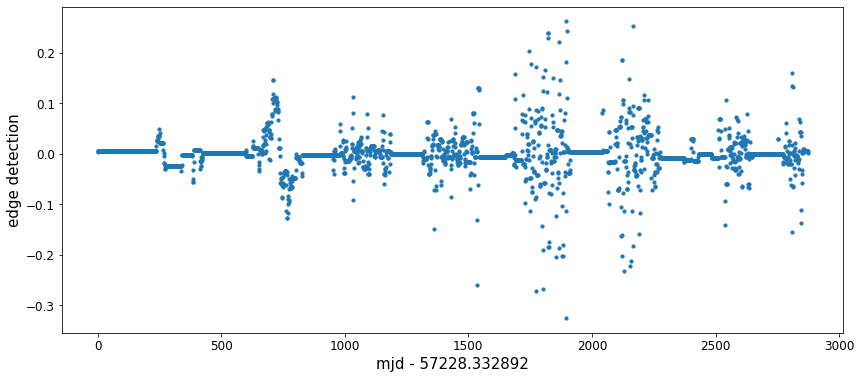

In [32]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,new_edge_detect,s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('edge detection')
# plt.ylim(-1,1)
plt.show()

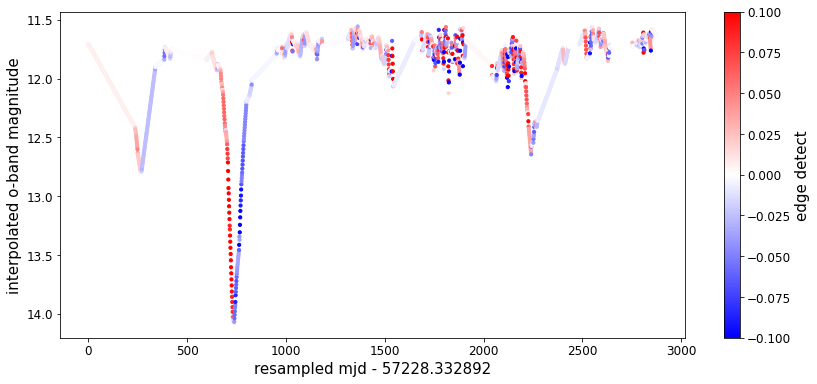

In [33]:
plt.figure(figsize=(14,6))
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.scatter(resample_time,resample_flux,s=10,
            c=new_edge_detect,cmap='bwr')#,alpha=0.2)
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-0.1,0.1)
# lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# plt.clim(-lim,lim)
# plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
plt.show()

# Actually all the GP stuff should go here :)

In [81]:
kernel = Matern(length_scale=3, nu=3/2) + WhiteKernel(noise_level=1) #+ ConstantKernel()
# kernel = RBF(length_scale=1,length_scale_bounds=(1e-05, 10)) + WhiteKernel(noise_level=1) #+ ConstantKernel()

In [82]:
# median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m']

time = np.asarray(savgol_filtered_oband['mjd']-mjd_scale)
time = time.reshape(-1,1)

In [84]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
# gp.fit(time, savgol_filtered_oband['m']-np.min(savgol_filtered_oband['m']))
gp.fit(time, savgol_filtered_oband['m'])
# GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
#                 kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1),
#                 n_restarts_optimizer=0, normalize_y=False,
#                 optimizer='fmin_l_bfgs_b', random_state=None)

GaussianProcessRegressor(kernel=Matern(length_scale=3, nu=1.5) + WhiteKernel(noise_level=1))

In [85]:
gp.kernel_

Matern(length_scale=233, nu=1.5) + WhiteKernel(noise_level=0.00568)

### big question: what resolution should I resample to?

Probably once a night is fine, RCBs shouldn't vary much more than that??

In [86]:
x_pred = np.linspace(0, int(np.max(time))+1, int(np.max(time))+1).reshape(-1,1)
y_pred, sigma = gp.predict(x_pred, return_std=True)

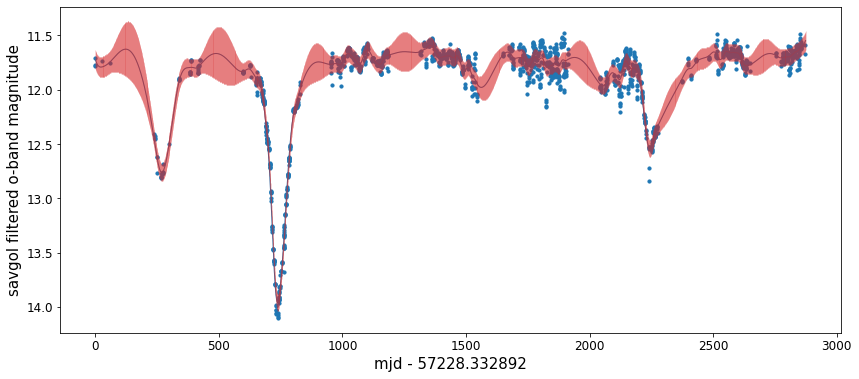

In [87]:
plt.figure(figsize=(14,6))

# plt.plot(x_pred,y_pred+np.min(savgol_filtered_oband['m']))
# plt.errorbar(x_pred, y_pred+np.min(savgol_filtered_oband['m']), yerr=sigma, capsize=0, color='tab:red',alpha=0.2)
plt.plot(x_pred,y_pred)
plt.errorbar(x_pred, y_pred, yerr=sigma, capsize=0, color='tab:red',alpha=0.2)

plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('savgol filtered o-band magnitude')
# plt.xlim(1000,3000)
plt.show()

In [88]:
gpsmoothed_time = time
gpsmoothed_flux, gpsigma = gp.predict(gpsmoothed_time, return_std=True)

In [89]:
# plt.figure(figsize=(14,6))

# plt.plot(x_pred,y_pred)
# plt.errorbar(x_pred, y_pred, yerr=sigma, capsize=0, color='tab:red',alpha=0.2)

# plt.scatter(gpsmoothed_time,gpsmoothed_flux,color='tab:green',zorder=3)

# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10)
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('savgol filtered o-band magnitude')
# # plt.xlim(1000,3000)
# plt.show()

In [90]:
gp_edge_detect = sp.ndimage.convolve(y_pred, [1.0, 0.0, -1.0])

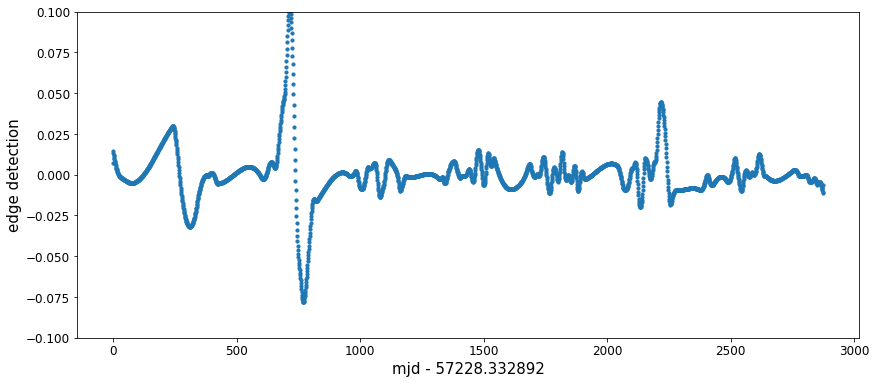

In [91]:
# np.std()

plt.figure(figsize=(14,6))
plt.scatter(x_pred,gp_edge_detect,s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('edge detection')
plt.ylim(-0.1,0.1)
plt.show()

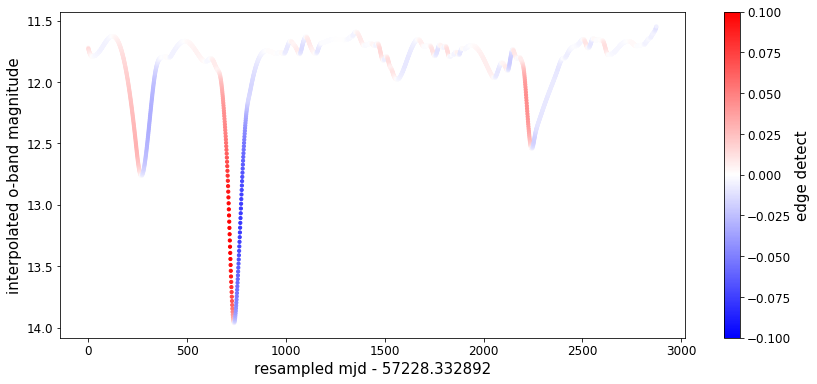

In [44]:
plt.figure(figsize=(14,6))
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.scatter(x_pred,y_pred,s=10,
            c=gp_edge_detect,cmap='bwr')#,alpha=0.2)
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-0.1,0.1)
# lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# plt.clim(-lim,lim)
# plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
plt.show()

In [45]:
## interpolate the edge detection to convert back to the original times
# np.linspace(0, int(np.max(time)), int(np.max(time)))
gp_edgedetect_interp = sp.interpolate.interp1d(x_pred[:,0],
                                                 gp_edge_detect,
                                                 kind='slinear')

gp_edges = gp_edgedetect_interp(savgol_filtered_oband['mjd']-mjd_scale)

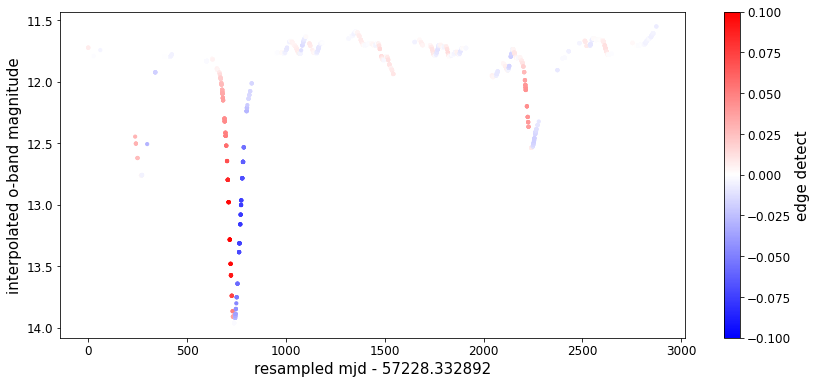

In [46]:
plt.figure(figsize=(14,6))
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.scatter(gpsmoothed_time,gpsmoothed_flux,s=10,
            c=gp_edges,cmap='bwr')#,alpha=0.2)
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-0.1,0.1)
# lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# plt.clim(-lim,lim)
# plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
plt.show()

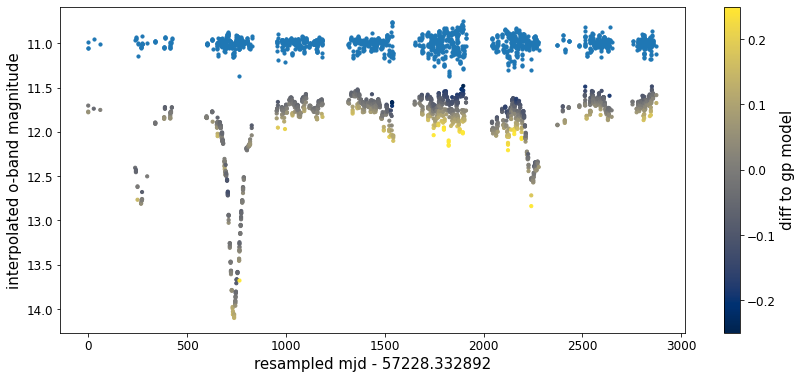

In [47]:
plt.figure(figsize=(14,6))

plt.scatter(gpsmoothed_time,(savgol_filtered_oband['m']-gpsmoothed_flux)+11,
            s=10)#,c=gp_edges,cmap='bwr')
plt.scatter(gpsmoothed_time,savgol_filtered_oband['m'],s=10,
            c=savgol_filtered_oband['m']-gpsmoothed_flux,cmap='cividis')#,alpha=0.2)

plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.colorbar(label='diff to gp model')
plt.clim(-0.25,0.25)
plt.show()

# Now back to normal

In [48]:
## interpolate the edge detection to convert back to the original times
# edge_detect_interp_func = sp.interpolate.interp1d(resample_time,
#                                                  new_edge_detect,
#                                                  kind='slinear')

# edges_realdata = edge_detect_interp_func(median_filtered_oband['mjd']-mjd_scale)


In [49]:
# plt.figure(figsize=(14,6))
# plt.scatter(median_filtered_oband['mjd']-mjd_scale,edges_realdata,s=10)
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('edge detect back to real data')
# # plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# # plt.clim(-1,1)
# plt.show()

In [50]:
# plt.figure(figsize=(14,6))
# # plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(edges_realdata+3)*4,s=10)
# plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,
#             c=(edges_realdata),cmap='bwr')
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('median filtered o-band magnitude')
# plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# plt.clim(-0.1,0.1)
# # plt.xlim(950,1200)
# # plt.xlim(500,1000)
# # plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
# plt.show()

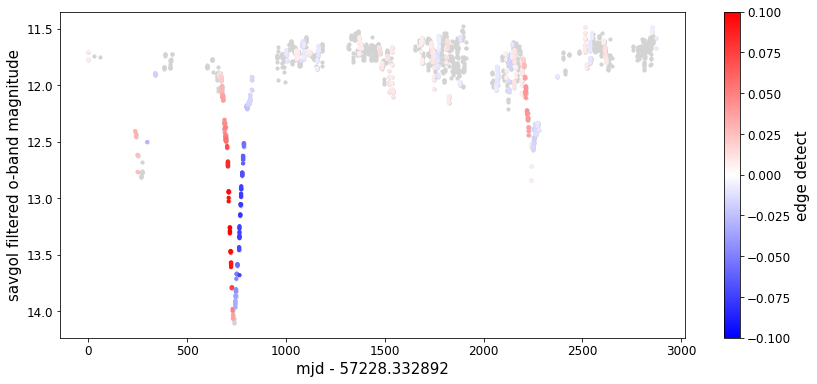

In [51]:
std_dev = np.std(gp_edges)
# std_dev
new_mask = np.where(np.abs(gp_edges)>(std_dev*0.25),True,False)

plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(gp_edges+3)*4,s=10)
plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,color='lightgrey')
plt.scatter(savgol_filtered_oband['mjd'][new_mask]-mjd_scale,savgol_filtered_oband['m'][new_mask],s=10,
            c=(gp_edges[new_mask]),cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('savgol filtered o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

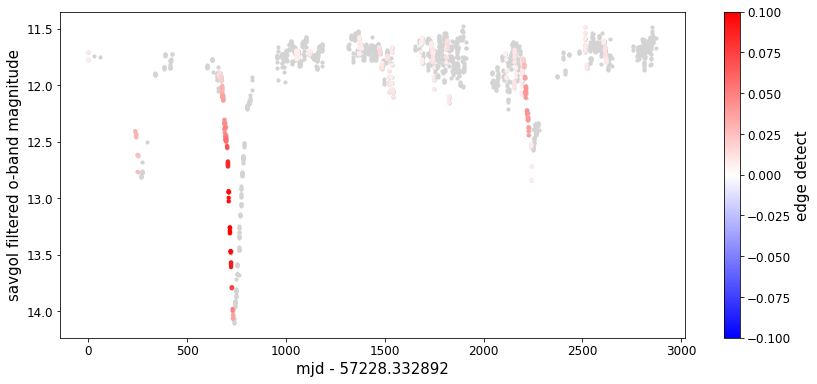

In [52]:
std_dev = np.std(gp_edges)
new_mask = np.where(np.abs(gp_edges)>(std_dev*0.25),True,False)
downslope_mask = np.where(gp_edges>0.0,True,False)
total_mask = new_mask & downslope_mask

plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(gp_edges+3)*4,s=10)
plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,color='lightgrey')
plt.scatter(savgol_filtered_oband['mjd'][total_mask]-mjd_scale,savgol_filtered_oband['m'][total_mask],s=10,
            c=(gp_edges[total_mask]),cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('savgol filtered o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

In [53]:
print(savgol_filtered_oband['mjd'][total_mask]-mjd_scale)

0          0.000000
1          0.025139
2          0.051789
5        237.325536
6        241.165739
           ...     
1528    2620.717790
1529    2620.720507
1530    2621.652599
1531    2621.658007
1532    2621.675503
Name: mjd, Length: 418, dtype: float64


In [54]:
def find_runs(x):
    x = np.asanyarray(x)
    n = x.shape[0]
    
    # find run starts
    loc_run_start = np.empty(n, dtype=bool)
    loc_run_start[0] = True
    np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
    run_starts = np.nonzero(loc_run_start)[0]

    # find run values
    run_values = x[loc_run_start]

    # find run lengths
    run_lengths = np.diff(np.append(run_starts, n))

    return run_values, run_starts, run_lengths

In [55]:
run_vals, run_start, run_length = find_runs(total_mask)

In [56]:
downward_mask = run_start[np.logical_and(run_vals==True,run_length > 3)]
upward_mask = run_start[np.logical_and(run_vals==False,run_length > 3)]

In [57]:
savgol_filtered_oband['mjd'][downward_mask]-mjd_scale

5        237.325536
79       663.208079
401     1051.085986
471     1118.958399
599     1369.175506
732     1471.061884
771     1512.930985
790     1534.885611
810     1683.204744
852     1735.206516
955     1811.058198
1127    2109.211747
1197    2155.049274
1241    2192.042289
1367    2512.060251
1504    2606.410357
Name: mjd, dtype: float64

In [58]:
savgol_filtered_oband['mjd'][run_start]

0       57228.332892
3       57256.259894
5       57465.658428
12      57495.479900
79      57891.540971
204     57966.333234
401     58279.418878
425     58293.385615
471     58347.291291
479     58361.272971
599     58597.508398
619     58617.505181
732     58699.394776
752     58717.297482
771     58741.263877
787     58759.217257
790     58763.218503
802     58879.639233
810     58911.537636
822     58919.562015
852     58963.539408
875     58981.540398
955     59039.391090
971     59055.342743
1127    59337.544639
1135    59347.445104
1197    59383.382166
1214    59393.425692
1241    59420.375181
1303    59477.231938
1367    59740.393143
1383    59766.224207
1504    59834.743249
1533    59854.769027
Name: mjd, dtype: float64

In [59]:
savgol_filtered_oband['m'][run_start]

0       11.704
3       11.739
5       12.406
12      12.803
79      11.929
204     14.059
401     11.716
425     11.812
471     11.705
479     11.748
599     11.673
619     11.753
732     11.680
752     11.819
771     11.744
787     12.038
790     12.035
802     11.683
810     11.631
822     11.750
852     11.626
875     11.708
955     11.802
971     11.746
1127    11.716
1135    11.993
1197    11.974
1214    11.673
1241    12.068
1303    12.535
1367    11.589
1383    11.803
1504    11.608
1533    11.774
Name: m, dtype: float64

In [60]:
decline_onset = []
decline_end = []
for i in range(0,len(savgol_filtered_oband['m'][run_start])):
    if i == 0 and np.abs(savgol_filtered_oband['m'].iloc[0] - savgol_filtered_oband['m'][run_start[i+1]]) > 0.8:
        ## adding the absolute magnitude should detect beginning declines
        ## NEEDS TO BE TESTED
        decline_onset.append(0)
        print('beginning')
        print('0')
        print(savgol_filtered_oband['mjd'][0])
        print(np.abs(savgol_filtered_oband['m'].iloc[0] - savgol_filtered_oband['m'][run_start[i]]))
    elif i == len(savgol_filtered_oband['m'][run_start])-1:
        if savgol_filtered_oband['m'].iloc[-1] - savgol_filtered_oband['m'][run_start[i]] > 0.8:
            decline_onset.append(run_start[i])
            print('end')
            print(run_start[i])
            print(savgol_filtered_oband['mjd'][run_start[i]])
            print(savgol_filtered_oband['m'].iloc[-1] - savgol_filtered_oband['m'][run_start[i]])
    elif savgol_filtered_oband['m'][run_start[i+1]] - savgol_filtered_oband['m'][run_start[i]] > 0.8:#1:
        decline_onset.append(run_start[i])
        print(run_start[i])
        print(savgol_filtered_oband['mjd'][run_start[i]])
        print(savgol_filtered_oband['m'][run_start[i+1]] - savgol_filtered_oband['m'][run_start[i]])
#     if i == len(savgol_filtered_oband['m'][run_start]):
#         print('end')

79
57891.540971
2.129999999999999


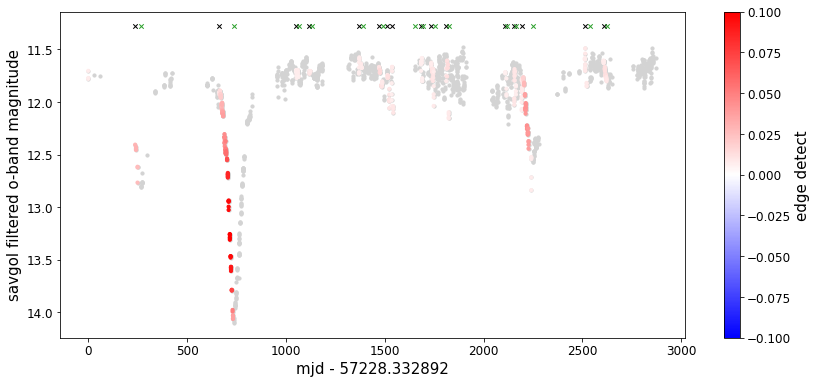

In [61]:
plt.figure(figsize=(14,6))
plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,color='lightgrey')
plt.scatter(savgol_filtered_oband['mjd'][downward_mask]-mjd_scale,
            np.full(len(savgol_filtered_oband['mjd'][downward_mask]),np.min(savgol_filtered_oband['m']))-0.2
                    ,s=20,marker='x',color='k',zorder=3)
plt.scatter(savgol_filtered_oband['mjd'][upward_mask]-mjd_scale,
            np.full(len(savgol_filtered_oband['mjd'][upward_mask]),np.min(savgol_filtered_oband['m']))-0.2
                    ,s=20,marker='x',color='tab:green',zorder=3)
# plt.scatter(savgol_filtered_oband['mjd'][decline_onset]-mjd_scale,
#             np.full(len(savgol_filtered_oband['mjd'][decline_onset]),np.min(savgol_filtered_oband['m']))-0.2,
#                     s=20,marker='x',color='k',zorder=3)
plt.scatter(savgol_filtered_oband['mjd'][total_mask]-mjd_scale,savgol_filtered_oband['m'][total_mask],s=10,
            c=(gp_edges[total_mask]),cmap='bwr')

plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('savgol filtered o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
plt.show()

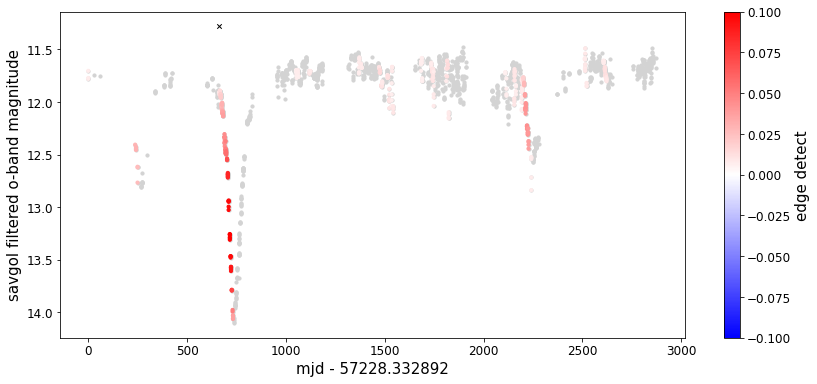

In [62]:
plt.figure(figsize=(14,6))
plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,color='lightgrey')
# plt.scatter(savgol_filtered_oband['mjd'][downward_mask]-mjd_scale,
#             np.full(len(savgol_filtered_oband['mjd'][downward_mask]),np.min(savgol_filtered_oband['m']))-0.2
#                     ,s=20,marker='x',color='k',zorder=3)
# plt.scatter(savgol_filtered_oband['mjd'][upward_mask]-mjd_scale,
#             np.full(len(savgol_filtered_oband['mjd'][upward_mask]),np.min(savgol_filtered_oband['m']))-0.2
#                     ,s=20,marker='x',color='tab:green',zorder=3)
plt.scatter(savgol_filtered_oband['mjd'][decline_onset]-mjd_scale,
            np.full(len(savgol_filtered_oband['mjd'][decline_onset]),np.min(savgol_filtered_oband['m']))-0.2,
                    s=20,marker='x',color='k',zorder=3)
plt.scatter(savgol_filtered_oband['mjd'][total_mask]-mjd_scale,savgol_filtered_oband['m'][total_mask],s=10,
            c=(gp_edges[total_mask]),cmap='bwr')

plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('savgol filtered o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
# plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight')
plt.show()